# GPEX data

This example uses Global Precipitation EXtremes dataset GPEX from  This data was used for article: Extreme Precipitation Return Levels for Multiple Durations on a Global Scale, Gründemann et al., 2021. (https://doi.org/10.1016/j.jhydrol.2023.129558)

The data set `GPEX.nc` can be downloaded from https://opendap.4tu.nl/thredds/catalog/data2/fig/12764429/4/catalog.html. The data file contains global estimates of extreme precipitation using four extreme value methods (GEV, POT, Gumbel and MEV) for eight durations (3 hours - 10 days).

See page https://data.4tu.nl/articles/_/12764429/4 for more details.

In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import geopandas as gpd
import regionmask
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

imagery = OSM(cache=True)

/usr/local/share/venvs/sci/lib/python3.10/site-packages/cartopy/io/img_tiles.py:113: UserWarning: Cartopy created the following directory to cache GoogleWTS tiles: /var/folders/8l/qwchy9rd09x6v46zs3_zbmxm0000gn/T/cartopy_cache_dir/OSM
  warnings.warn(


Open downloaded data set. The spatial resolution is 0.1°.

In [2]:
ds = xr.open_dataset('~/DATA/GPEX/GPEX.nc')
ds

<xarray.Dataset>
Dimensions:             (lat: 1480, lon: 3600, dur: 8, tr: 10, year: 38)
Coordinates:
  * lat                 (lat) float32 89.95 89.85 89.75 ... -57.75 -57.85 -57.95
  * lon                 (lon) float64 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * dur                 (dur) int32 3 6 12 24 48 72 120 240
  * tr                  (tr) int32 2 5 10 20 39 50 100 200 500 1000
  * year                (year) int32 0 1 2 3 4 5 6 7 ... 30 31 32 33 34 35 36 37
Data variables: (12/26)
    gev_estimate        (lat, lon, dur, tr) float32 ...
    pot_estimate        (lat, lon, dur, tr) float32 ...
    mev_estimate        (lat, lon, dur, tr) float32 ...
    gumbel_estimate     (lat, lon, dur, tr) float32 ...
    observed_estimate   (lat, lon, dur, tr) float32 ...
    gev_location        (lat, lon, dur) float32 ...
    ...                  ...
    gumbel_location     (lat, lon, dur) float32 ...
    gumbel_scale        (lat, lon, dur) float32 ...
    annual_maximum      (lat, lon, dur, year) float32 ...
    hydroyear           (lat, lon) float32 ...
    running_parameter   (lat, lon) timedelta64[ns] ...
    mask                (lat, lon) uint8 ...
Attributes:
    title:           GPEX
    description:     Global Precipitation EXtremes dataset. This data was use...
    acknowledgment:  Contains modified Multi-Source Weighted-Ensemble Precipi...
    authors:         Gaby Gründemann, Enrico Zorzetto, Hylke Beck, Marc Schle...
    date_created:    2021-08-25
    creator_name:    Gaby Gründemann
    creator_email:   g.j.gruendemann@tudelft.nl
    institution:     Department of Water Management, Faculty of Civil Enginee...
    conventions:     CF 1.7

For illustration, we use shape file for Haliacmon river drainage basin and select a rectangular area around the basin.

In [4]:
shape = gpd.read_file('Drainage_basin/basin.shp')
bb = shape.to_crs('EPSG:4326').bounds.values[0]

bb = bb + [-0.1, -0.1, 0.1, 0.1]
ds2 = ds.sel(lon=slice(bb[0], bb[2]), lat=slice(bb[3], bb[1]))

shape.to_crs('EPSG:4326').bounds

,minx,miny,maxx,maxy
0,20.776522,39.818271,21.959666,40.809015


Plot with a background map.

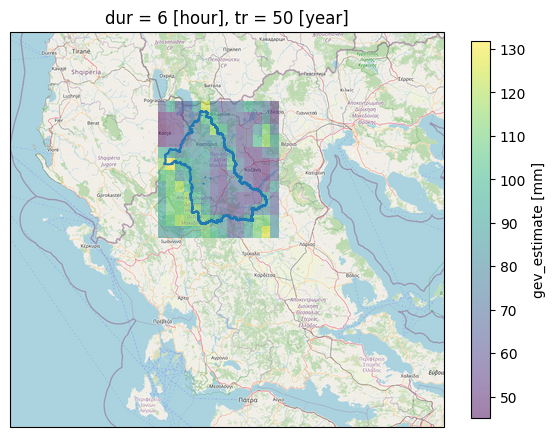

In [5]:
tr = 50
dur = 6

p0 = imagery.crs
p1 = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(7, 7),  subplot_kw={'projection': p0})
ax.set_extent(np.r_[19.0, 24.0, 38, 41.5], crs=p1)

ax.add_image(imagery, 8, interpolation='spline36')
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)

gev = ds2['gev_estimate'].sel(tr=tr, dur=dur)
m = gev.plot.pcolormesh(x='lon', y='lat',
                        transform=p1, ax=ax, alpha=0.5,
                        cbar_kwargs={'shrink': 0.7})
plt.show()

Plot one return period for several event durations, dur [h].

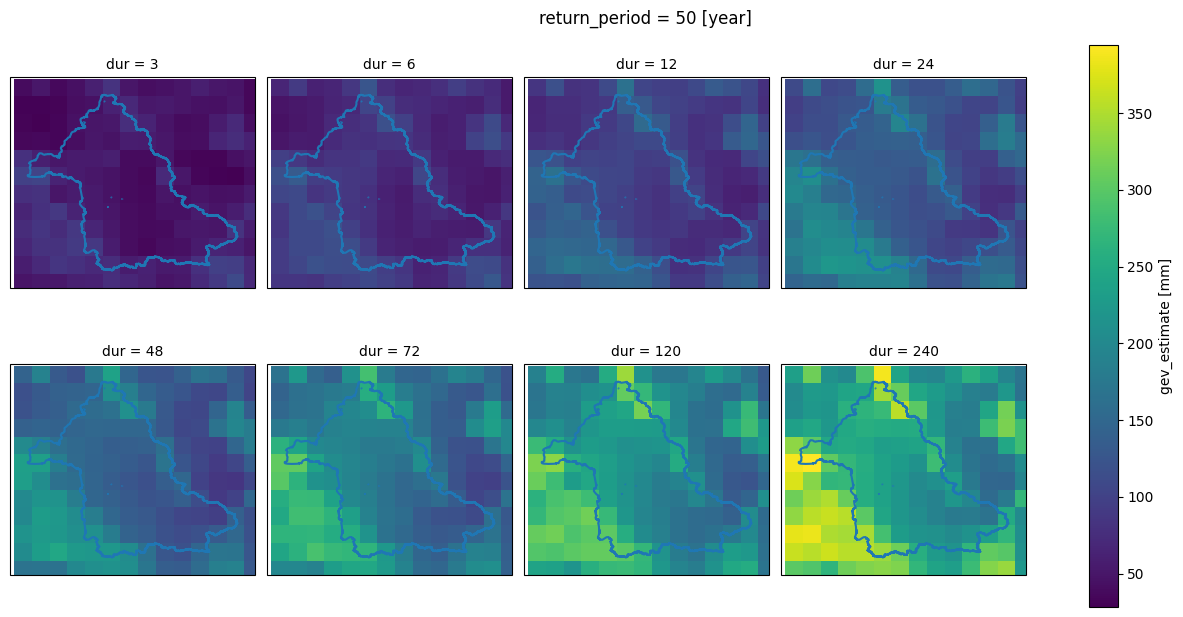

In [6]:
tr = 50

gev = ds2['gev_estimate'].sel(tr=tr)
m = gev.plot.pcolormesh(x='lon', y='lat', col='dur', col_wrap=4,
                        transform=p1,
                        subplot_kws={'projection': p1})
plt.suptitle(f'{gev.tr.attrs.get("long_name")} = {gev.tr.values} [{gev.tr.attrs.get("units")}]', y=1.02)

for ax in m.axs.ravel():
    ax.set_extent(np.r_[bb[0], bb[2], bb[1], bb[3]], crs=p1)
    shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)

plt.show()

# IDF intensity - duration - frequency curves

IDF curves can be used for various hydrological analyses. In GPEX data, intensity is calculated from precipitation and duration. The data has 10 return periods from 2 to 1000 years. Below, we mask the data to select only pixels for Heliacmon river basin. Then we calculate averge IDF curves over the areas for all provided return periods.

In [7]:
mask = regionmask.mask_geopandas(shape.to_crs('EPSG:4326'),
                                 ds['lat'].values,
                                 ds['lat'].values,
                                 lon_name='lon', lat_name='lat')

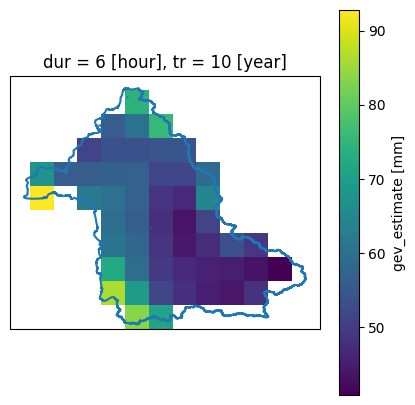

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),  subplot_kw={'projection': p1})
ds['gev_estimate'].sel(tr=10, dur=6).where(mask==0, drop=True).plot(transform=p1)
shape.to_crs(p1).boundary.plot(ax=ax, transform=p1)
plt.show()

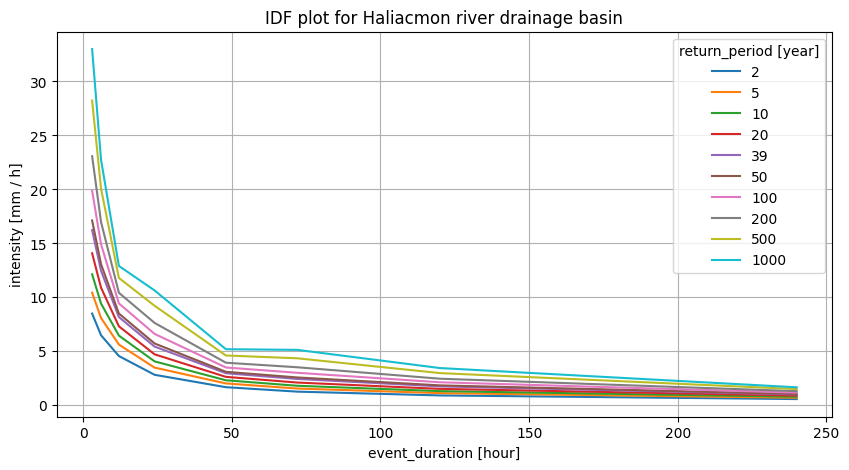

In [9]:
plt.figure(figsize=(10, 5))

gevmean = ds['gev_estimate'].where(mask==0, drop=True).mean(dim=['lon', 'lat'])
(gevmean / gevmean['dur']).plot.line(x='dur')
plt.ylabel('intensity [mm / h]')
plt.grid()
plt.title('IDF plot for Haliacmon river drainage basin')
plt.show()